# Baseline Model

## Table of Contents
1. [Model Choice](#model-choice)
2. [Feature Selection](#feature-selection)
3. [Implementation](#implementation)
4. [Evaluation](#evaluation)


In [2]:
# Import necessary libraries

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image

import tensorflow as tf

from keras.src.legacy.preprocessing.image import ImageDataGenerator

from matplotlib.ticker import StrMethodFormatter


## Model Choice

We have chosen a very basic CNN as the base model. Unlike time series or regression-like tasks for image classification there are no "readily implemented" or easily available non-NN machine learning models available. Or to be more precise: if we do not want to du "manual" image precossing for feature extraction etc., which could be used to for decision tree or random forest approaches, we only have neural networks left. Therefore, we chose a simple CNN with only 2 convolutional layers and 2 dense layers as a baseline model.

Such a simple model can already perform the relevant classification in principle while still having enough room for improvement.


## Feature Selection

In the case of our dataset only the image themselves contain relevant information for the classification task. As far as we know and have tested there is no correlation between Label types and the 'window' and 'lib' features. Thus, only the image itself is used as a feature in both the baseline model and most likely any other models as well.


In [7]:
# Path Definitions to relevant data + data loading

base_file_path = 'C:/Users/nikoLocal/Documents/Opencampus/Machine_Vision_challenge_data/'
image_path = base_file_path + '/input_train/input_train'

label_csv_name = 'Y_train_eVW9jym.csv'

submission_csv_name = 'Y_random_nKwalR1.csv'
submission_image_path = base_file_path + '/input_test_1a4aqAg/input_test'

#Loading .csv data to dataframes
train_df = pd.read_csv(os.path.join(base_file_path, label_csv_name))
submission_test_df = pd.read_csv(os.path.join(base_file_path, submission_csv_name))

In [12]:
#DataFrame Preprocessing

#Hyperparameters:
test_split = 0.2
val_split = 0.20 # remember - this is fractional  after the test data has been split from the initial balanced sub dataset

#add another column to the dataframe according to dictionaries to map Labels correctly to numbers
dict_numbers = {'GOOD': 0,'Boucle plate':1,'Lift-off blanc':2,'Lift-off noir':3,'Missing':4,'Short circuit MOS':5}
dict_strings = {'GOOD': '0_GOOD','Boucle plate':'1_Flat loop','Lift-off blanc':'2_White lift-off','Lift-off noir':'3_Black lift-off','Missing':'4_Missing','Short circuit MOS':'5_Short circuit MOS'}
# for Test Data ("random submission" dataframe)
dict_strings_sub = {0: '0_GOOD',1:'1_Flat loop',2:'2_White lift-off',3:'3_Black lift-off',4:'4_Missing',5:'5_Short circuit MOS',6:'6_Drift'}

#list of all labels in the data
label_list = ['0_GOOD','1_Flat loop','2_White lift-off','3_Black lift-off','4_Missing','5_Short circuit MOS']

#create new columns in DFs via .map() method
train_df['LabelNum'] = train_df['Label'].map(dict_numbers)
train_df['LabelStr'] = train_df['Label'].map(dict_strings)

submission_test_df['LabelStr'] = submission_test_df['Label'].map(dict_strings_sub)

num_classes = len(label_list)

# get counts of label with the least entries
countList = train_df['LabelStr'].value_counts()
minCounts = countList.min()

BalancedDF = pd.DataFrame()
#concat sampled dataframes for each included label
for i in range(num_classes):
    BalancedDF = pd.concat([BalancedDF,train_df[train_df['LabelStr'] == label_list[i]].sample(n=minCounts)],axis=0)

#test if worked as intended
print(BalancedDF['LabelStr'].value_counts())

#split dataframe according to fractional test size
train_df_balanced, test_df_balanced = train_test_split(BalancedDF, test_size=test_split, random_state=42) #keep random state constant to ensure

LabelStr
0_GOOD                 71
1_Flat loop            71
2_White lift-off       71
3_Black lift-off       71
4_Missing              71
5_Short circuit MOS    71
Name: count, dtype: int64


In [13]:
# initialize ImageDataGenerators
# use ImageDataGen because it has method flow_from_dataframe() that works really well together with pandas dataframes
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# although deprecated the functionality can be used as discussed in feedback session

# HYPERPARAMTERS ########

target_size = (256,256) #pixel size to load img
class_mode = 'categorical' # how to store labels - either categorical (one-hot encoding) or as numbers
#class_mode = 'input'
batch_size = 8 #later player around with batch size to see how it affects performance
labelCol = 'LabelStr'
#########################

#normalize pixel intensities
rescale = 1.0/255.0

datagen = ImageDataGenerator(
    horizontal_flip=False,
    vertical_flip=False,
    rotation_range=0.0,
    shear_range=0.0,
    rescale=rescale,
    validation_split=val_split)

datagen_augmentation = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=35,
    shear_range= 12,
    zoom_range = 0.10,
    rescale=rescale,
    validation_split=val_split)

datagen_test = ImageDataGenerator(
    horizontal_flip=False,
    vertical_flip=False,
    rotation_range=0.0,
    shear_range=0.0,
    rescale=rescale,
    validation_split=0.0)

datagen_submission_test = ImageDataGenerator(
    horizontal_flip=False,
    vertical_flip=False,
    rotation_range=0.0,
    shear_range=0.0,
    rescale=rescale,
    validation_split=0.0)

##########################################################

train_generator = datagen.flow_from_dataframe(
    train_df_balanced,
    image_path,
    x_col='filename',
    y_col=labelCol,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    color_mode="grayscale",
    shuffle=True,
    seed=42,
    subset='training')

train_generator_val = datagen.flow_from_dataframe(
    train_df_balanced,
    image_path,
    x_col='filename',
    y_col=labelCol,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    color_mode="grayscale",
    shuffle=True,
    seed=42,
    subset='validation')

train_generator_aug = datagen_augmentation.flow_from_dataframe(
    train_df_balanced,
    image_path,
    x_col='filename',
    y_col=labelCol,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    color_mode="grayscale",
    shuffle=True,
    seed=42,
    subset='training')

train_generator_aug_val = datagen_augmentation.flow_from_dataframe(
    train_df_balanced,
    image_path,
    x_col='filename',
    y_col=labelCol,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    color_mode="grayscale",
    shuffle=True,
    seed=42,
    subset='validation')

# To Do - make another Test gen. It does not really need to be balanced
# keep now for testing purposes - lower runtime

test_generator = datagen_test.flow_from_dataframe(
    test_df_balanced,
    image_path,
    x_col='filename',
    y_col=labelCol,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    color_mode="grayscale",
    shuffle=True,
    seed=42,
    subset='training')

test_generator_metrics = datagen_submission_test.flow_from_dataframe(
    test_df_balanced,
    image_path,
    x_col='filename',
    y_col=labelCol,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=1,
    color_mode="grayscale",
    shuffle=False,
    seed=42,
    subset='training')

#generator for submission test data

test_generator_submission = datagen_test.flow_from_dataframe(
    submission_test_df,
    submission_image_path,
    x_col='filename',
    y_col='LabelStr',
    target_size=target_size,
    class_mode=class_mode,
    batch_size=1,
    color_mode="grayscale",
    shuffle=False,
    seed=42,
    subset='training')

Found 255 validated image filenames belonging to 6 classes.
Found 85 validated image filenames belonging to 6 classes.
Found 255 validated image filenames belonging to 6 classes.
Found 85 validated image filenames belonging to 6 classes.
Found 86 validated image filenames belonging to 6 classes.
Found 86 validated image filenames belonging to 6 classes.
Found 1055 validated image filenames belonging to 7 classes.


## Implementation





In [14]:
# build a model to be used as baseline model
# use "simplest" CNN as baseline

model_simple_CNN = tf.keras.Sequential([
    tf.keras.layers.Input((target_size[0], target_size[1], 1)),  #image are greyscale - so in total dim (width,height,1)
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(num_classes, activation="softmax"),
])

model_simple_CNN.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    31,490,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,509,766 (120.20 MB)

 Trainable params: 31,509,766 (120.20 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# compile Model

model_simple_CNN.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    #loss=tf.keras.losses.SparseCategoricalCrossentropy,
    #metrics=["accuracy",'precision',]
    metrics=["accuracy",'precision','recall',tf.keras.metrics.F1Score(average='weighted')]
)

#F1 average parameter needs to be anything other than None if using linewise output when fiting the model...

# callback that monitors validation accuracy / loss
# https://keras.io/api/callbacks/early_stopping/
val_loss_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=12,
    restore_best_weights=True,
    verbose = 2
)

In [16]:
history = model_simple_CNN.fit(
    train_generator_aug,
    validation_data = train_generator_val,
    epochs=50,
    callbacks=[val_loss_stop],
    verbose = 2 #2 is one line per epoch -
)

Epoch 1/50
32/32 - 12s - 369ms/step - accuracy: 0.1882 - f1_score: 0.1486 - loss: 4.4446 - precision: 0.1458 - recall: 0.0275 - val_accuracy: 0.0941 - val_f1_score: 0.0165 - val_loss: 1.7755 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
32/32 - 10s - 316ms/step - accuracy: 0.2863 - f1_score: 0.1867 - loss: 1.6423 - precision: 1.0000 - recall: 0.0235 - val_accuracy: 0.5059 - val_f1_score: 0.4295 - val_loss: 1.4744 - val_precision: 1.0000 - val_recall: 0.0706
Epoch 3/50
32/32 - 10s - 305ms/step - accuracy: 0.5529 - f1_score: 0.5467 - loss: 1.1751 - precision: 0.7732 - recall: 0.2941 - val_accuracy: 0.4706 - val_f1_score: 0.4454 - val_loss: 1.0722 - val_precision: 0.7209 - val_recall: 0.3647
Epoch 4/50
32/32 - 10s - 302ms/step - accuracy: 0.6667 - f1_score: 0.6702 - loss: 0.9086 - precision: 0.7471 - recall: 0.5098 - val_accuracy: 0.6588 - val_f1_score: 0.6351 - val_loss: 0.8784 - val_precision: 0.6622 - val_recall: 0.5765
Epoch 5/50
32/32 - 10s - 321ms/step - accuracy: 

## Evaluation

We choose to evaluate most available metrics. However, a focus will be put on the F1 score.
With more available information / better models we will likely shift towards using a single metric to rank model performance.

We are classifying correctly working vs defective parts. In the context of machine vision inspection it is more desirable to false detect a defect (falso positive) then to miss a defect. Thus, recall seems like the best metric to use.
However, the classification is not binary but consisting of 6 (7) classes. There are multiple defective classes and one good (as well as one undefined/ misc class). Consequently, either each class should use its own metric. Alternatively, the F1-score could be used for all classes giving a mean evaluation of precision and recall. In this stage of the project we will use the F1 score to evaluate models and hyperparameters.
In order to fully evaluate all models we will also save a classification report to file using sklearn.metrics.classification_report for calculation.


In [23]:
# test accuracy on test data
test_loss, test_accuracy, test_precision, test_recall,test_f1_score = model_simple_CNN.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.3g} | Test Loss: {test_loss:.3g} | Test Precision: {test_precision:.3g} | Test Recall: {test_recall:.3g} | Test F1 Score: {test_f1_score:.3g}:")


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8721 - f1_score: 0.8716 - loss: 0.4547 - precision: 0.9012 - recall: 0.8488
Test Accuracy: 0.872 | Test Loss: 0.455 | Test Precision: 0.901 | Test Recall: 0.849 | Test F1 Score: 0.872:


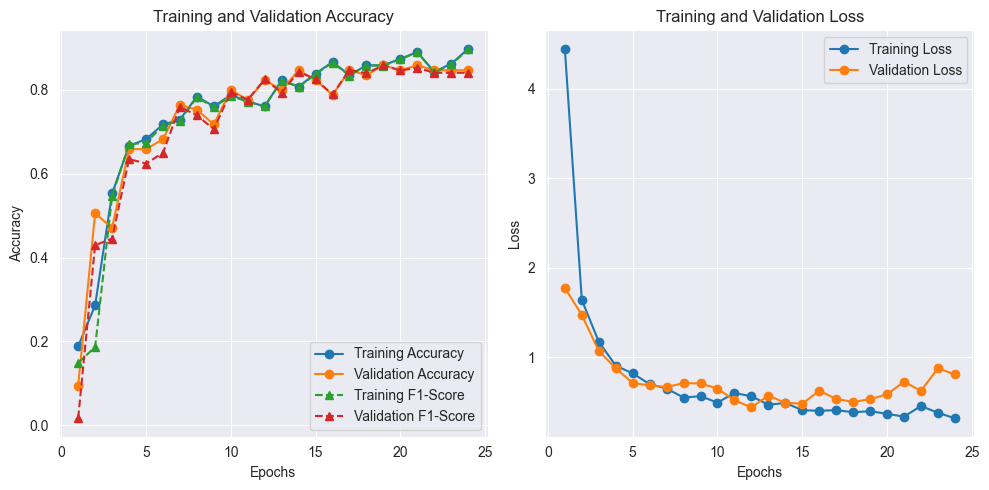

In [18]:
# Accuracy, F1 score and losses

training_accuracy = history.history["accuracy"]
validation_accuracy = history.history["val_accuracy"]

training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]

training_f1 = history.history["f1_score"]
validation_f1 = history.history["val_f1_score"]

# Setting up the number of epochs for the x-axis
epochs_range = range(1, len(training_accuracy) + 1)

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy,'o-', label="Training Accuracy")
plt.plot(epochs_range, validation_accuracy,'o-', label="Validation Accuracy")
plt.plot(epochs_range, training_f1,'^--', label="Training F1-Score")
plt.plot(epochs_range, validation_f1,'^--', label="Validation F1-Score")
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss,'o-', label="Training Loss")
plt.plot(epochs_range, validation_loss,'o-', label="Validation Loss")
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
#get predicted and true labels for the test dataset

#get true labels from generator:
#  https://stackoverflow.com/questions/45413712/keras-get-true-labels-y-test-from-imagedatagenerator-or-predict-generator

from keras.utils import to_categorical

# test_generator.labels and test_generator.classes seem to be identical
#test_generator_metrics.classes

true_labels = test_generator_metrics.classes
#make into one hot encoding
#true_labels = to_categorical(true_labels, num_classes=6)

# model.predict directly gives you the output of the last mode layer. so percentages when using i.e. 'softmax'
predicted_labels = model_simple_CNN.predict(test_generator_metrics)

#convert to numerical - np.argmax directly does the job
predicted_labels = np.argmax(predicted_labels, axis=-1)

86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [20]:
#classification report does NOT work with one hot encoding
print(classification_report(true_labels, predicted_labels,target_names = label_list))

#save as dict for future use as well

report = classification_report(true_labels, predicted_labels,target_names = label_list,output_dict=True)
#convert to dataframe for easy use and saving to csv
report_df = pd.DataFrame(report).transpose()

#save to file
metrics_baseline_savename = base_file_path + '/' + 'metrics_baseline.csv'

report_df.to_csv(metrics_baseline_savename)

                     precision    recall  f1-score   support

             0_GOOD       0.89      0.94      0.91        17
        1_Flat loop       0.73      0.89      0.80        18
   2_White lift-off       0.82      0.64      0.72        14
   3_Black lift-off       1.00      0.92      0.96        13
          4_Missing       0.90      1.00      0.95         9
5_Short circuit MOS       1.00      0.87      0.93        15

           accuracy                           0.87        86
          macro avg       0.89      0.88      0.88        86
       weighted avg       0.88      0.87      0.87        86



## Including challange test data and the 'drift' class

Setup most simple baseline model for Test data including the "Drift" class (Class No. 6)
Test against the random submission / publicly available Test data. Careful: the labels cannot be assumed to be the true labels - therefore take the results as an indication only.
(From challenge leaderboard it can be assumed, that the labels are at least ~85% accurate)

We use a very simple combinational model for this task:

Output of the previously trained model + tresholding. If the model is not confident enough (output < treshold) we assign the drift class ( Class No. 6)

In [21]:
#make a prediction for each available Public test dataset item
#
pred_label_list = list()

#total treshold
# test which value makes sense. Unique treshold per class would likely be much better
certainty_threshold = 0.8

# loop doesn't stop - why?
# test_generator_metrics is not shuffled
i_run = 0
for data in test_generator_submission:
    prediction = model_simple_CNN.predict(data,verbose=0)

    predicted_label = np.argmax(prediction, axis=-1)[0]
    label_certainty = prediction[0][predicted_label]

    #check whether label is predicted with high certainty
    if label_certainty > certainty_threshold:
        pred_label_list.append(predicted_label)
    else:
        pred_label_list.append(6) #append drift label if model is too uncertain


    i_run = i_run + 1
    if i_run == len(test_generator_submission):
        print("{} items processed".format(i_run))
        break

C:\Users\nikoLocal\PycharmProjects\MV_Valeo_Opencampus\.venv\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=('Tensor(shape=(1, 256, 256, 1))', 'Tensor(shape=(1, 7))')
  warnings.warn(msg)


1055 items processed


In [22]:
# add column to dataframe

submission_test_df_compare = submission_test_df.copy(deep=True)
submission_test_df_compare['predicted Labels'] = pred_label_list

#save to file
submission_csv_comparison_save = base_file_path + '/' + submission_csv_name + '_predicted.csv'

submission_test_df_compare.to_csv(submission_csv_comparison_save)

Quick manual inspection of a few image and labels of the comparison shows, that the submissions labels are wrong most of the time.
In conclusion this data CANNOT be used to train or evaluate any models.

The data could be used, however, to train detection of "Drift" data by manually creating labeled data to find possible drift images.
-> Do this in a python program that automatically loads images and gives you the option for Drift / no drift.